In [65]:
from sklearn.metrics import precision_recall_curve
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [66]:
from google.colab import drive
drive.mount('/content/drive')

video_name = 'news'

if video_name == 'ngc':
  PATH = f'/content/drive/MyDrive/python_data/多媒體內容分析/hw1/{video_name}.mpeg'
else:
  PATH = f'/content/drive/MyDrive/python_data/多媒體內容分析/hw1/{video_name}.mpg'
  
with open(f'/content/drive/MyDrive/python_data/多媒體內容分析/hw1/{video_name}_ground.txt', 'r') as f:
  gt = []
  lines = [line.strip() for line in f.readlines()[4:]]
  for line in lines:
    if '~' in list(line):
      st, en = line.split('~')
      gt += list(range(int(st), int(en)+1))
    else:
      gt.append(int(line))
  print(gt)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[73, 235, 301, 370, 452, 861, 1281]


# PR CURVE

In [67]:
def pr_curve(preds, gt):
  count= 0

  for f_idx in preds:
    if f_idx in gt:
      count += 1
  # print(f'precision: {round(count/len(preds),2)}')
  precision = round(count/len(preds),2)

  count= 0
  for f_idx in gt:
    if f_idx in preds:
      count += 1
  # print(f'recall: {round(count/len(gt),2)}')
  recall = round(count/len(gt),2)

  return precision, recall

# Edge Change Ratio

In [68]:
def ECR(frame, prev_frame, width, height, crop=True, dilate_rate = 5):
    safe_div = lambda x,y: 0 if y == 0 else x / y
    if crop:
        startY = int(height * 0.3)
        endY = int(height * 0.8)
        startX = int(width * 0.3)
        endX = int(width * 0.8)
        frame = frame[startY:endY, startX:endX]
        prev_frame = prev_frame[startY:endY, startX:endX]

    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(gray_image, 0, 200)
    dilated = cv2.dilate(edge, np.ones((dilate_rate, dilate_rate)))
    inverted = (255 - dilated)
    gray_image2 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    edge2 = cv2.Canny(gray_image2, 0, 200)
    dilated2 = cv2.dilate(edge2, np.ones((dilate_rate, dilate_rate)))
    inverted2 = (255 - dilated2)
    log_and1 = (edge2 & inverted)
    log_and2 = (edge & inverted2)
    pixels_sum_new = np.sum(edge)
    pixels_sum_old = np.sum(edge2)
    out_pixels = np.sum(log_and1)
    in_pixels = np.sum(log_and2)
    return max(safe_div(float(in_pixels),float(pixels_sum_new)), safe_div(float(out_pixels),float(pixels_sum_old)))

In [69]:
ECR_list = []

video = cv2.VideoCapture(PATH)
width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
height = video.get(cv2.CAP_PROP_FRAME_WIDTH)
video.set(3, width)
video.set(4, height)
prev_frame = None
while True:
    ret, frame = video.read()
    if frame is None:
        break
    if prev_frame is not None:
        ECR_list.append(ECR(frame, prev_frame, width, height))
    prev_frame = frame
video.release()

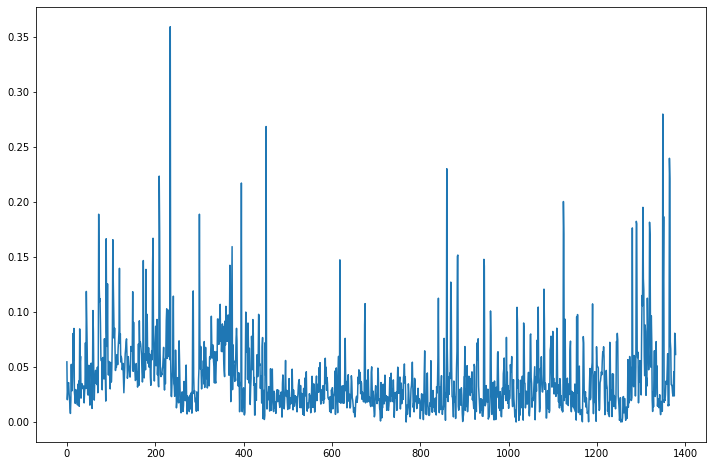

In [70]:
fig = plt.figure(figsize= (12,8))
plt.plot(ECR_list)

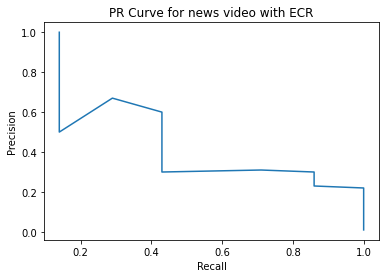

In [71]:
ps = []
rs = []
for threshold in range(1, 30):
  preds = [i+1 for i, f in enumerate(ECR_list) if f>threshold*0.01]
  precision, recall = pr_curve(preds, gt)
  ps.append(precision)
  rs.append(recall)
plt.plot(rs, ps)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curve for {video_name} video with ECR')
plt.savefig(f'{video_name}_ECR.jpeg')

# Twin Comparison

In [72]:
class Frame:
    SD=-1
    hist = []
    index = -1
    img = None
    isCut= False

In [73]:
class TwinComparionDetect():
  def __init__(self, Tb= 60000, Ts= 20000):
    self.Tb = Tb  # 较高的阈值
    self.Ts = Ts  # 较低的阈值
    self.Fs = -1  # 渐变开始的下标
    self.Fe = -1  # 渐变结束的下标
    self.isbegin = False
    self.myFrames = []
    self.step = 30
    self.list_sd = []
    self.num = 0

  def ColorHistTwinComparisonDetect(self, VideoPATH):

      cap = cv2.VideoCapture(VideoPATH)  # 提取视频
      index = -1
      # plt.figure()
      # plt.title("Flattened Color Histogram")
      # plt.xlabel("Bins")
      # plt.ylabel("# of Pixels")

      while (cap.isOpened()):

          ret, frame = cap.read()
          if ret == False:
              break
          index += 1
          if index>= 3563:
              break

          img = frame
          temp_frame = Frame()
          temp_frame.index = index
          temp_frame.img = img.copy()
          self.myFrames.append(temp_frame)

          img = cv2.GaussianBlur(img, (9, 9), 0.0)  # 做高斯模糊
          img= cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
          h, s,v = cv2.split(img)
          hist_h = cv2.calcHist([h], [0], None, [256], [0, 256])  # 计算直方图
          hist_s = cv2.calcHist([s], [0], None, [256], [0, 256])  # 计算直方图
          hist_v = cv2.calcHist([v], [0], None, [256], [0, 256])  # 计算直方图
          weight= [0.5,0.3,0.2]
          hist = weight[0] * hist_h + weight[1] * hist_s + weight[2] * hist_v

          # plt.plot(hist)
          # plt.xlim([0, 256])

          temp_frame.hist = hist

          if len(self.myFrames) >= 2:
              sd = 0
              last_Frame = self.myFrames[len(self.myFrames) - 2]
              last_hist = last_Frame.hist

              for i in range(0, 256):
                  sd += abs(hist[i]-last_hist[i])

              last_Frame.SD = sd
              self.list_sd.append(sd)
              # print(index, sd)

              if sd >= self.Tb: # 帧间差大于Tb, 是突变
                  self.num += 1
                  last_Frame.isCut = True
                  self.isbegin=False
              elif sd >= self.Ts:# 帧间差大于Ts，小于Tb，是可能的渐变起点
                  self.Fs = last_Frame.index
                  self.isbegin = True  # 进入渐变过程
                  # print("Fs", Fs)
              elif sd < self.Ts:
                  if self.isbegin == True: # 如果处于渐变过程
                      diffsd= 0
                      for i in range(0, 256): # 累积差
                          diffsd += abs(last_Frame.hist[i] - self.myFrames[self.Fs].hist[i])
                      if diffsd>= self.Tb: # 累积差超过Tb，算作渐变结束点
                          self.Fe = last_Frame.index
                          last_Frame.isCut= True
                          self.isbegin= False
                          # print("Fe", self.Fe)
                      elif last_Frame.index - self.Fs > self.step: # 帧间差小于Ts，累积差小于Tb，步长超过渐变的范围，放弃渐变开始点
                          self.isbegin = False

      cap.release()
      # plt.show()

      print(f'avg sd: {np.average(self.list_sd)}')
      print(f'max sd: {np.max(self.list_sd)}')
      print(self.num)

      detected_frames = []

      for i in range (0,len(self.myFrames)-1):
          if self.myFrames[i].isCut==True:
            detected_frames.append(self.myFrames[i].index)
            # print(f'detected frame: {self.myFrames[i].index}')
            # cv2.imwrite(result_path+"/" + str(myFrames[i].index) + ".png", myFrames[i].img)
      
      return detected_frames

In [74]:
detector = TwinComparionDetect()
preds = detector.ColorHistTwinComparisonDetect(PATH)

avg sd: 4243.09912109375
max sd: 84637.0
2


## test

avg sd: 4243.09912109375
max sd: 84637.0
87
avg sd: 4243.09912109375
max sd: 84637.0
9
avg sd: 4243.09912109375
max sd: 84637.0
7


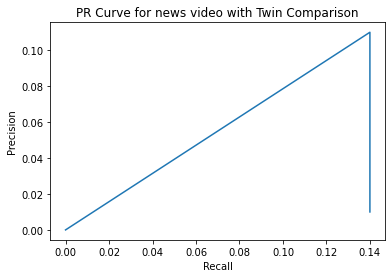

In [85]:
precisions = [] 
recalls = []

# for Tb in [75000, 70000, 65000, 60000]:
for Tb in [10000, 20000, 30000]:
  for Ts in [5000]:
    detector = TwinComparionDetect(Tb= Tb, Ts= Ts)
    preds = detector.ColorHistTwinComparisonDetect(PATH)
    precision, recall = pr_curve(preds, gt)
    precisions.append(precision)
    recalls.append(recall)
    # print(f'p: {precision}')

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curve for {video_name} video with Twin Comparison')
plt.savefig(f'{video_name}_Twin')

# TransNet 2

In [76]:
# !pip install tensorflow==2.1

## Model

In [77]:
!pip install ffmpeg-python

In [78]:
import os
import numpy as np
import tensorflow as tf


class TransNetV2:

    def __init__(self, model_dir=None):
        if model_dir is None:
            model_dir = os.path.join(os.path.dirname(__file__), "transnetv2-weights/")
            if not os.path.isdir(model_dir):
                raise FileNotFoundError(f"[TransNetV2] ERROR: {model_dir} is not a directory.")
            else:
                print(f"[TransNetV2] Using weights from {model_dir}.")

        self._input_size = (27, 48, 3)
        try:
            self._model = tf.saved_model.load(model_dir)
        except OSError as exc:
            raise IOError(f"[TransNetV2] It seems that files in {model_dir} are corrupted or missing. "
                          f"Re-download them manually and retry. For more info, see: "
                          f"https://github.com/soCzech/TransNetV2/issues/1#issuecomment-647357796") from exc

    def predict_raw(self, frames: np.ndarray):
        assert len(frames.shape) == 5 and frames.shape[2:] == self._input_size, \
            "[TransNetV2] Input shape must be [batch, frames, height, width, 3]."
        frames = tf.cast(frames, tf.float32)

        logits, dict_ = self._model(frames)
        single_frame_pred = tf.sigmoid(logits)
        all_frames_pred = tf.sigmoid(dict_["many_hot"])

        return single_frame_pred, all_frames_pred

    def predict_frames(self, frames: np.ndarray):
        assert len(frames.shape) == 4 and frames.shape[1:] == self._input_size, \
            "[TransNetV2] Input shape must be [frames, height, width, 3]."

        def input_iterator():
            # return windows of size 100 where the first/last 25 frames are from the previous/next batch
            # the first and last window must be padded by copies of the first and last frame of the video
            no_padded_frames_start = 25
            no_padded_frames_end = 25 + 50 - (len(frames) % 50 if len(frames) % 50 != 0 else 50)  # 25 - 74

            start_frame = np.expand_dims(frames[0], 0)
            end_frame = np.expand_dims(frames[-1], 0)
            padded_inputs = np.concatenate(
                [start_frame] * no_padded_frames_start + [frames] + [end_frame] * no_padded_frames_end, 0
            )

            ptr = 0
            while ptr + 100 <= len(padded_inputs):
                out = padded_inputs[ptr:ptr + 100]
                ptr += 50
                yield out[np.newaxis]

        predictions = []

        for inp in input_iterator():
            single_frame_pred, all_frames_pred = self.predict_raw(inp)
            predictions.append((single_frame_pred.numpy()[0, 25:75, 0],
                                all_frames_pred.numpy()[0, 25:75, 0]))

            print("\r[TransNetV2] Processing video frames {}/{}".format(
                min(len(predictions) * 50, len(frames)), len(frames)
            ), end="")
        print("")

        single_frame_pred = np.concatenate([single_ for single_, all_ in predictions])
        all_frames_pred = np.concatenate([all_ for single_, all_ in predictions])

        return single_frame_pred[:len(frames)], all_frames_pred[:len(frames)]  # remove extra padded frames

    def predict_video(self, video_fn: str):
        try:
            import ffmpeg
        except ModuleNotFoundError:
            raise ModuleNotFoundError("For `predict_video` function `ffmpeg` needs to be installed in order to extract "
                                      "individual frames from video file. Install `ffmpeg` command line tool and then "
                                      "install python wrapper by `pip install ffmpeg-python`.")

        print("[TransNetV2] Extracting frames from {}".format(video_fn))
        video_stream, err = ffmpeg.input(video_fn).output(
            "pipe:", format="rawvideo", pix_fmt="rgb24", s="48x27"
        ).run(capture_stdout=True, capture_stderr=True)

        video = np.frombuffer(video_stream, np.uint8).reshape([-1, 27, 48, 3])
        return (video, *self.predict_frames(video))

    @staticmethod
    def predictions_to_scenes(predictions: np.ndarray, threshold: float = 0.5):
        predictions = (predictions > threshold).astype(np.uint8)

        scenes = []
        t, t_prev, start = -1, 0, 0
        for i, t in enumerate(predictions):
            if t_prev == 1 and t == 0:
                start = i
            if t_prev == 0 and t == 1 and i != 0:
                scenes.append([start, i])
            t_prev = t
        if t == 0:
            scenes.append([start, i])

        # just fix if all predictions are 1
        if len(scenes) == 0:
            return np.array([[0, len(predictions) - 1]], dtype=np.int32)

        return np.array(scenes, dtype=np.int32)

    @staticmethod
    def visualize_predictions(frames: np.ndarray, predictions):
        from PIL import Image, ImageDraw

        if isinstance(predictions, np.ndarray):
            predictions = [predictions]

        ih, iw, ic = frames.shape[1:]
        width = 25

        # pad frames so that length of the video is divisible by width
        # pad frames also by len(predictions) pixels in width in order to show predictions
        pad_with = width - len(frames) % width if len(frames) % width != 0 else 0
        frames = np.pad(frames, [(0, pad_with), (0, 1), (0, len(predictions)), (0, 0)])

        predictions = [np.pad(x, (0, pad_with)) for x in predictions]
        height = len(frames) // width

        img = frames.reshape([height, width, ih + 1, iw + len(predictions), ic])
        img = np.concatenate(np.split(
            np.concatenate(np.split(img, height), axis=2)[0], width
        ), axis=2)[0, :-1]

        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)

        # iterate over all frames
        for i, pred in enumerate(zip(*predictions)):
            x, y = i % width, i // width
            x, y = x * (iw + len(predictions)) + iw, y * (ih + 1) + ih - 1

            # we can visualize multiple predictions per single frame
            for j, p in enumerate(pred):
                color = [0, 0, 0]
                color[(j + 1) % 3] = 255

                value = round(p * (ih - 1))
                if value != 0:
                    draw.line((x + j, y, x + j, y - value), fill=tuple(color), width=1)
        return img


def main():
    import sys
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("files", type=str, nargs="+", help="path to video files to process")
    parser.add_argument("--weights", type=str, default=None,
                        help="path to TransNet V2 weights, tries to infer the location if not specified")
    parser.add_argument('--visualize', action="store_true",
                        help="save a png file with prediction visualization for each extracted video")
    args = parser.parse_args()

    model = TransNetV2(args.weights)
    for file in args.files:
        if os.path.exists(file + ".predictions.txt") or os.path.exists(file + ".scenes.txt"):
            print(f"[TransNetV2] {file}.predictions.txt or {file}.scenes.txt already exists. "
                  f"Skipping video {file}.", file=sys.stderr)
            continue

        video_frames, single_frame_predictions, all_frame_predictions = \
            model.predict_video(file)

        predictions = np.stack([single_frame_predictions, all_frame_predictions], 1)
        np.savetxt(file + ".predictions.txt", predictions, fmt="%.6f")

        scenes = model.predictions_to_scenes(single_frame_predictions)
        np.savetxt(file + ".scenes.txt", scenes, fmt="%d")

        if args.visualize:
            if os.path.exists(file + ".vis.png"):
                print(f"[TransNetV2] {file}.vis.png already exists. "
                      f"Skipping visualization of video {file}.", file=sys.stderr)
                continue

            pil_image = model.visualize_predictions(
                video_frames, predictions=(single_frame_predictions, all_frame_predictions))
            pil_image.save(file + ".vis.png")


# if __name__ == "__main__":
#     main()

## Prediction

In [79]:
# location of learned weights is automatically inferred
# add argument model_dir="/path/to/transnetv2-weights/" to TransNetV2() if it fails
model = TransNetV2(model_dir= '/content/drive/MyDrive/python_data/多媒體內容分析/hw1/transnetv2-weights')
video_frames, single_frame_predictions, all_frame_predictions = model.predict_video(PATH)

[TransNetV2] Extracting frames from /content/drive/MyDrive/python_data/多媒體內容分析/hw1/news.mpg
[TransNetV2] Processing video frames 100/1380

KeyboardInterrupt: ignored

In [ ]:
detected_frames = [x[0] for x in model.predictions_to_scenes(single_frame_predictions, threshold= 0.01)][1:]

In [ ]:
# model.predictions_to_scenes(single_frame_predictions, threshold= 0.001)

In [ ]:
# pr_curve(preds= detected_frames, gt= gt)

In [ ]:
precisions = [] 
recalls = []

for threshold in [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]:
  try:
    detected_frames = [x[0] for x in model.predictions_to_scenes(single_frame_predictions, threshold= threshold)][1:]
    precision, recall = pr_curve(preds= detected_frames, gt= gt)
    precisions.append(precision)
    recalls.append(recall)
  except:
    pass

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curve for {video_name} video with TransNet V2')
plt.savefig(f'{video_name}_TransNet')